### Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
train.csv
test.csv

#### Задание:
 Используя данные из train.csv, построить
 модель для предсказания цен на недвижимость (квартиры).
 С помощью полученной модели предсказать
 цены для квартир из файла test.csv.

Целевая переменная:
Price

Основная метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Вспомогательная метрика:
MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

Сдача проекта:
1. Прислать в раздел Задания Урока 12 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).

Сроки сдачи:
Сдать проект за 72 часа до начала Урока 13 ("Вебинар. Результаты итоговых проектов и закрытие курса").

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 1. Загрузка данных, изучение

In [299]:
df = pd.read_csv('train.csv')

In [300]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


- необходимо восстановить LifeSquare
- необходимо восстановить Healthcare_1

In [301]:
df.head(15)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B,296021.204377
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,B,B,6,1437,3,NaN,0,2,B,95380.220993


- "Ecology_2", "Ecology_3", "Shops_2" в несколько бинарных
- столбец Id удалим, не несет информации

In [302]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


- проверить площадь кухни против площадь жилая
- проверить количество этаже в доме

In [377]:
(df['HouseFloor']-df['Floor']<0).value_counts()
# надо восстанавливать количество этаже в доме (не может быть 0 этажей и не может быть что этаж квартиры меньше чем этажей в доме)

False    8175
True     1825
dtype: int64

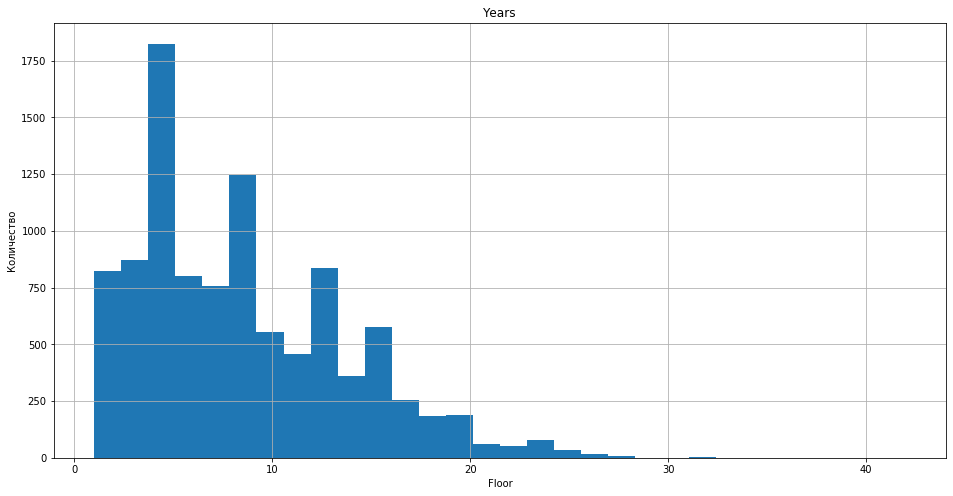

In [374]:
plt.figure(figsize = (16, 8))

df['Floor'].hist(bins=30)
plt.ylabel('Количество')
plt.xlabel('Floor')

plt.title('Years')
plt.show()

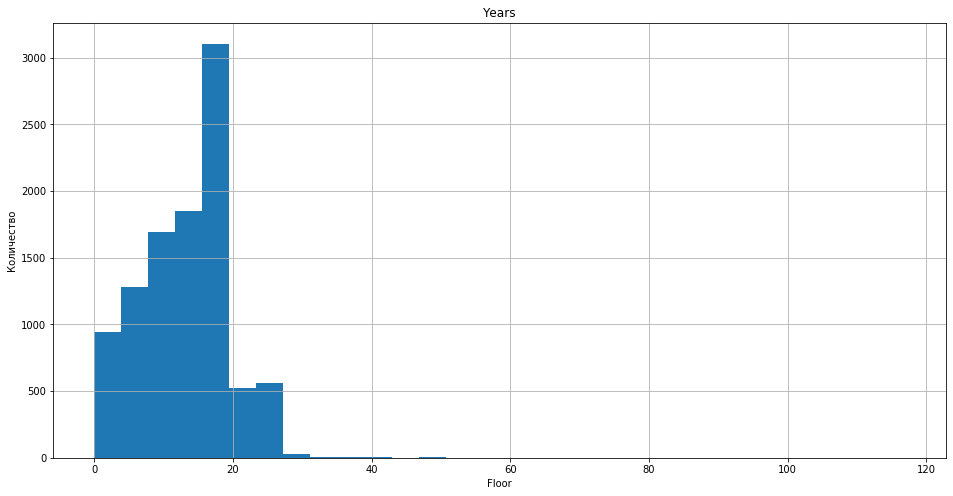

In [373]:
plt.figure(figsize = (16, 8))

df['HouseFloor'].hist(bins=30)
plt.ylabel('Количество')
plt.xlabel('Floor')

plt.title('Years')
plt.show()

Восстаналиваем год постройки - есть два больших выброс, их заменим на срдний год построкйи в Дистрикте

In [316]:
df.iloc[4189,8] = 1969
df.iloc[1497,8] = 1969

In [317]:
#1497
#4189
print(df.iloc[1497,:]['DistrictId'])
print(df.iloc[4189,:]['DistrictId'])
print(df[df['DistrictId']==147].agg({'HouseYear': 'mean'}))
print(df[df['DistrictId']==147].agg({'HouseYear': 'mean'}))

109
147
HouseYear    1969.0
dtype: float64
HouseYear    1969.0
dtype: float64


In [303]:
df['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
1970         194
1969         190
1972         178
1971         177
2018         175
1974         169
1968         162
1965         161
1963         158
1976         155
1973         150
1964         150
1975         150
1967         146
1966         140
1978         129
1962         125
1960         121
1961         113
1982         111
1981         108
1979         107
1980         107
2005         102
1983         101
            ... 
1952          10
1953          10
1931           7
1935           7
1950           7
1939           6
1918           5
1933           5
1937           5
1934           4
1938           4
1951           4
1940           4
1930           3
1942           3
1936           3
1919           3
1917           3
1912           2
1929           2
1932           2
1948           2
1941           2
4968           1
1914           1
1947           1
1916           1
1910          

In [304]:
df['HouseYear'].sort_values()

9317        1910
2656        1912
5111        1912
910         1914
7611        1916
5053        1917
1380        1917
8144        1917
1386        1918
2554        1918
2902        1918
8505        1918
5016        1918
7562        1919
4904        1919
2608        1919
9825        1928
8951        1929
3933        1929
8381        1930
6630        1930
4949        1930
5667        1931
7163        1931
2588        1931
8207        1931
3443        1931
8055        1931
6277        1931
6208        1932
          ...   
2916        2019
2904        2019
257         2019
5173        2019
4037        2019
8813        2019
1604        2019
4757        2019
8750        2019
3859        2020
6735        2020
585         2020
4493        2020
707         2020
790         2020
8253        2020
4376        2020
2877        2020
918         2020
3485        2020
2493        2020
9674        2020
4053        2020
7459        2020
3357        2020
7076        2020
5701        2020
1499        20

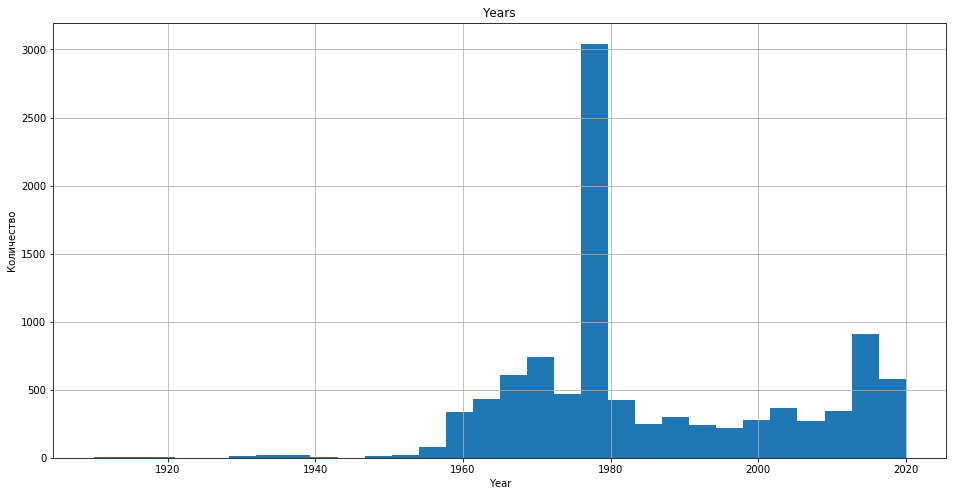

In [318]:
plt.figure(figsize = (16, 8))

df['HouseYear'].hist(bins=30)
plt.ylabel('Количество')
plt.xlabel('Year')

plt.title('Years')
plt.show()

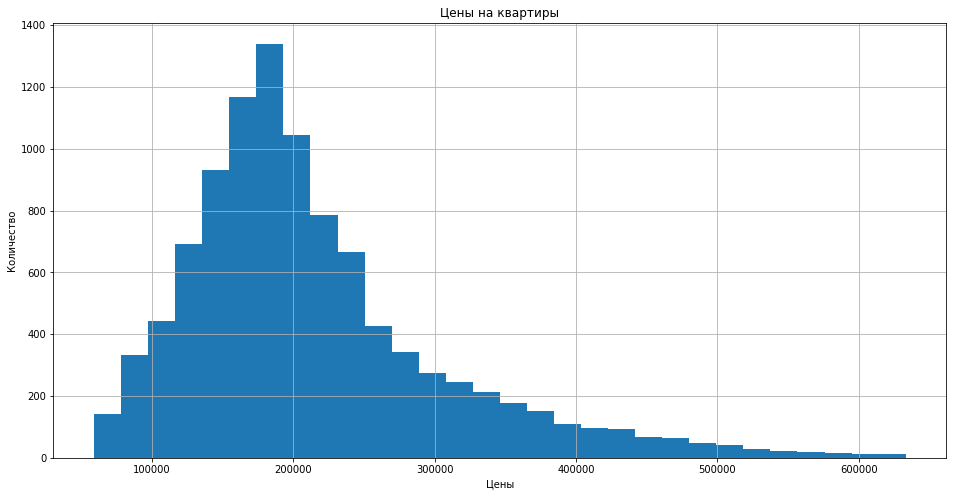

In [319]:
plt.figure(figsize = (16, 8))

df['Price'].hist(bins=30)
plt.ylabel('Количество')
plt.xlabel('Цены')

plt.title('Цены на квартиры')
plt.show()

- выбросов нет, распределение нормальное

### 2. Подготовка данных

признаки "Ecology_2", "Ecology_3", "Shops_2" в несколько бинарных

In [320]:
df = pd.get_dummies(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Price            10000 non-null float64
Ecology_2_A      10000 non-null uint8
Ecology_2_B      10000 non-null uint8
Ecology_3_A      10000 non-null uint8
Ecology_3_B      10000 non-null uint8
Shops_2_A        10000 non-null uint8
Shops_2_B        10000 non-null uint8
dtyp

In [321]:
#sns.pairplot(df[df.columns.tolist()[:8] + ['Price']])

In [322]:
#sns.pairplot(df[df.columns.tolist()[8:16] + ['Price']])

In [323]:
#sns.pairplot(df[df.columns.tolist()[16:]])

### 3. Восстанавливаем LifeSquare

In [324]:
df_ls = df.copy()

In [325]:
df_ls.sort_values(['LifeSquare'], ascending=False).head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
4328,16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,...,NaN,0,0,217357.492366,0,1,0,1,0,1
6977,11602,30,2.0,641.065193,638.163193,10.0,20,19.0,2019,0.000078,...,1046.0,3,23,133529.681562,0,1,0,1,0,1
8437,15886,85,3.0,78.059331,461.463614,10.0,12,16.0,1998,0.037178,...,2300.0,1,7,394253.299978,0,1,0,1,0,1
4690,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,...,705.0,3,6,90470.430830,0,1,0,1,0,1
590,14990,23,2.0,48.449873,263.542020,5.0,6,5.0,1972,0.075779,...,NaN,0,2,141780.231857,0,1,0,1,0,1


In [326]:
df_ls[df_ls['LifeSquare']-df_ls['Square']>0].count()[0]

482

482 квартир с некорректным занчением LifeSquare. LifeSquare не может быть меньше Square.

- удалим Healthcare_1 посклько в нем пока мало значений и для нас не информативный
- убираем из тренировочного сета LifeSquare с незаполненным значением и с некорректным

In [327]:
df_ls = df_ls[pd.isna(df_ls['LifeSquare'])==False] #.reset_index()
df_ls = df_ls[df_ls['LifeSquare']-df_ls['Square']<0].reset_index()

df_ls = df_ls.drop(['index'], axis=1)
#df_ls = df_ls.drop(['Healthcare_1'], axis=1)
#df_ls = df_ls.drop(['Id'], axis=1)

In [328]:
df_ls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405 entries, 0 to 7404
Data columns (total 23 columns):
Id               7405 non-null int64
DistrictId       7405 non-null int64
Rooms            7405 non-null float64
Square           7405 non-null float64
LifeSquare       7405 non-null float64
KitchenSquare    7405 non-null float64
Floor            7405 non-null int64
HouseFloor       7405 non-null float64
HouseYear        7405 non-null int64
Ecology_1        7405 non-null float64
Social_1         7405 non-null int64
Social_2         7405 non-null int64
Social_3         7405 non-null int64
Healthcare_1     4288 non-null float64
Helthcare_2      7405 non-null int64
Shops_1          7405 non-null int64
Price            7405 non-null float64
Ecology_2_A      7405 non-null uint8
Ecology_2_B      7405 non-null uint8
Ecology_3_A      7405 non-null uint8
Ecology_3_B      7405 non-null uint8
Shops_2_A        7405 non-null uint8
Shops_2_B        7405 non-null uint8
dtypes: float64(8), int64(

список признаков

In [329]:
target_ = 'LifeSquare'
# data_lifesquare.columns.to_list() 'Id','DistrictId',
features_ = ['DistrictId','Rooms', 'Square', 'KitchenSquare', 'Floor', 
             'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 
             'Social_3', 'Helthcare_2', 'Shops_1', 'Price', 'Ecology_2_A',
             'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B']

In [330]:
features_std = df_ls[features_].select_dtypes(include=['float64','int64']).columns.tolist()
# features_std

нормализация параметров

In [331]:
scl = StandardScaler()
scl_f = scl.fit_transform(df_ls[features_std])

In [332]:
df_ls[features_std] =  pd.DataFrame(scl_f, columns=features_std)

In [333]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [334]:
X = df_ls[features_]
y = df_ls[target_]

In [336]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

**Linear Regression**

In [337]:
l_model = LinearRegression()
l_model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

R2:	0.681
MAE:	5.857
MSE:	103.5


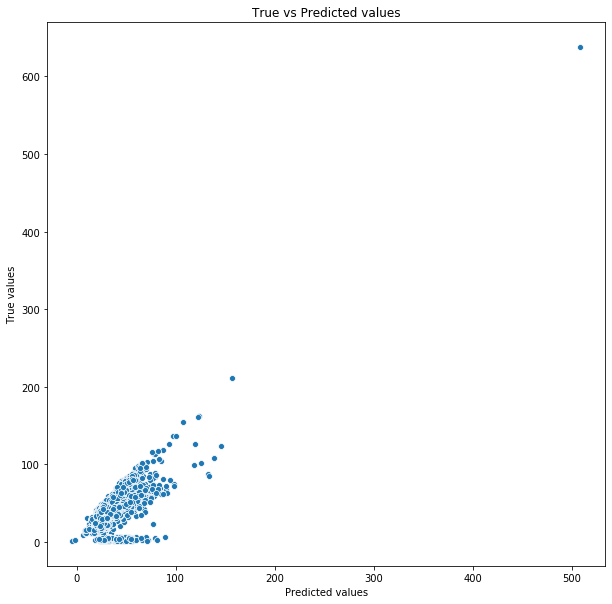

R2:	0.638
MAE:	5.876
MSE:	94.312


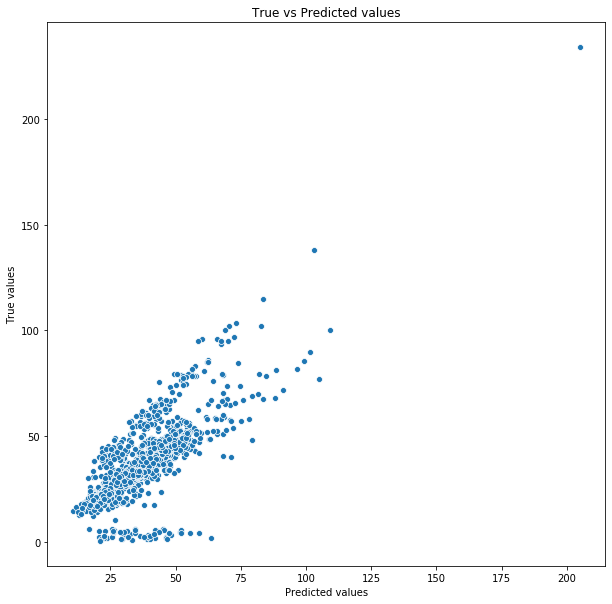

In [338]:
y_pred_l=l_model.predict(X_train)
evaluate_preds(y_train, y_pred_l)

y_pred_lt=l_model.predict(X_test)
evaluate_preds(y_test, y_pred_lt)

**Lasso regression**

R2:	0.681
MAE:	5.838
MSE:	103.585


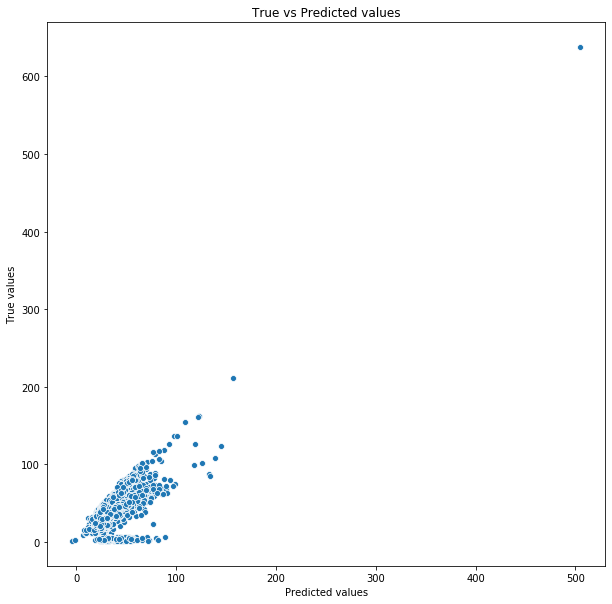

R2:	0.64
MAE:	5.838
MSE:	93.761


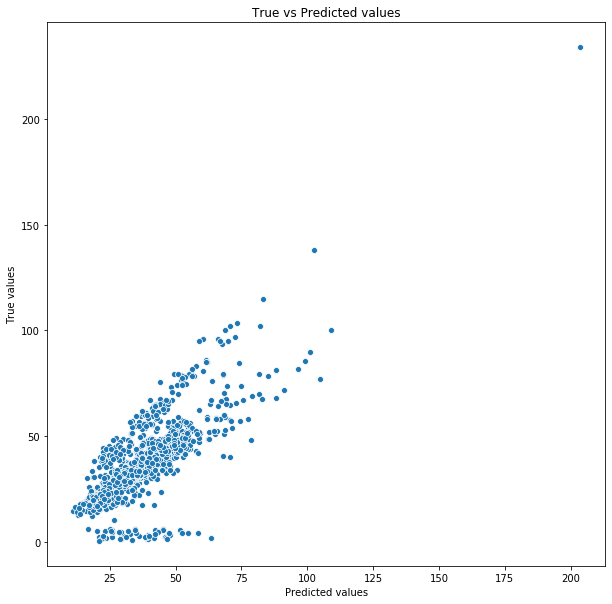

In [339]:
L_model = Lasso(alpha=0.05)
L_model.fit(X_train, y_train)
y_pred_L = L_model.predict(X_train)
evaluate_preds(y_train, y_pred_L)

y_pred_Lt = L_model.predict(X_test)
evaluate_preds(y_test, y_pred_Lt)

**Random Forest**

R2:	0.934
MAE:	2.03
MSE:	21.528


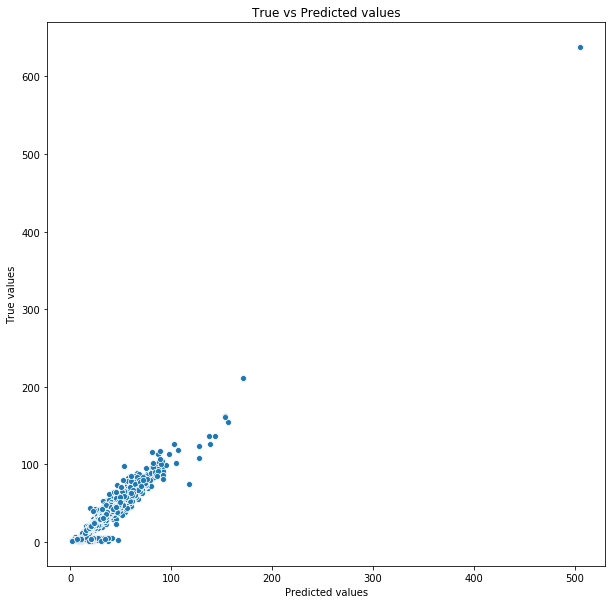

R2:	0.596
MAE:	4.919
MSE:	105.156


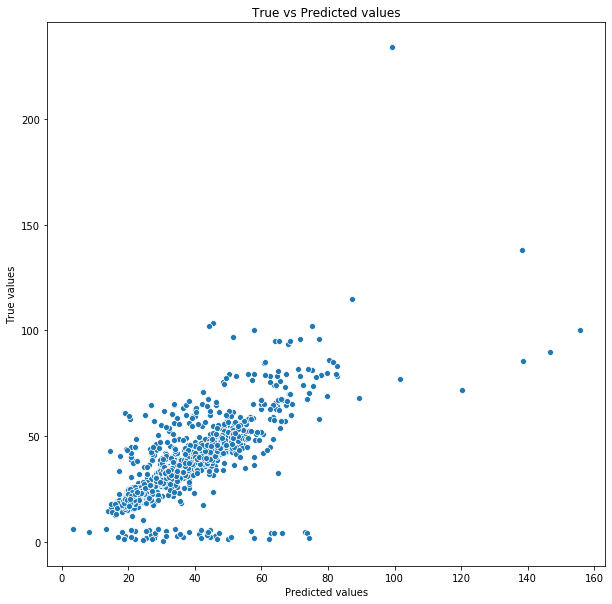

In [340]:
R_model = RandomForestRegressor()
R_model.fit(X_train,y_train)

y_pred_R=R_model.predict(X_train)
evaluate_preds(y_train, y_pred_R)

y_pred_Rt=R_model.predict(X_test)
evaluate_preds(y_test, y_pred_Rt)

**Gradient Boosting**

R2:	0.805
MAE:	4.357
MSE:	63.408


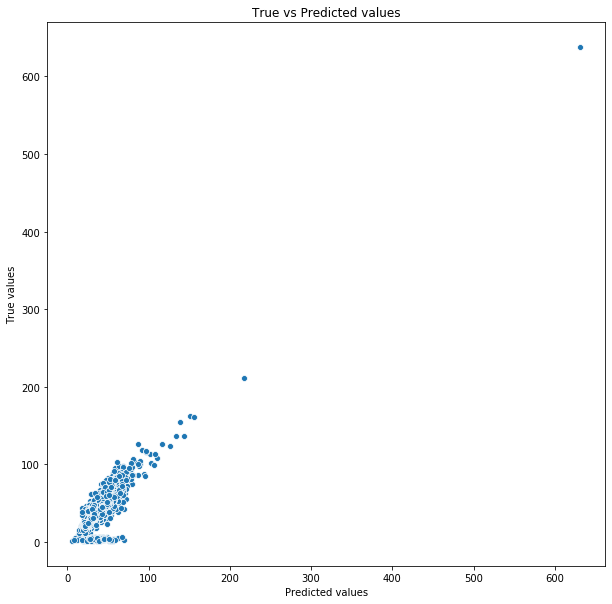

R2:	0.694
MAE:	4.686
MSE:	79.586


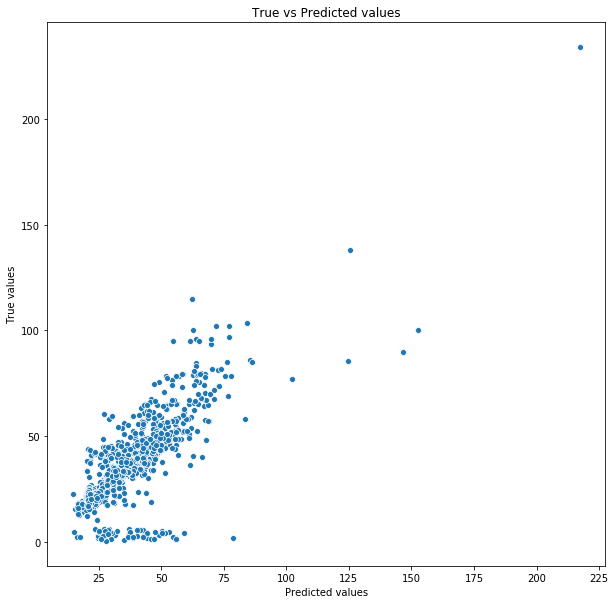

In [341]:
G_model = GradientBoostingRegressor()
G_model.fit(X_train,y_train)

y_pred_G=G_model.predict(X_train)
evaluate_preds(y_train, y_pred_G)

y_pred_Gt=G_model.predict(X_test)
evaluate_preds(y_test, y_pred_Gt)

### 3.1. Выбираем модель Gradient Boosting. Подбираем оптимальные параметры.

In [342]:
model = GradientBoostingRegressor(random_state=42)
model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [343]:
param={'n_estimators':[5, 10, 50, 100, 150, 300, 450], 'max_depth':[1,3,5,7,10,15]}

In [350]:
gd=GridSearchCV(model, param, scoring='r2',cv = KFold(n_splits=3,random_state = 42))
gd.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_we..._fraction_leaf=0.0,
                                                 n_estimators=100,
                            

In [352]:
gd.best_params_

{'max_depth': 1, 'n_estimators': 300}

In [357]:
model_best = GradientBoostingRegressor(max_depth=gd.best_params_['max_depth'], 
                                       n_estimators=gd.best_params_['n_estimators'], 
                                       random_state=42,
                                       #learning_rate=0.1,
                                       #alpha=0.01,
                                       #subsample=0.9
                                      )
model_best.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=1,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=300,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.743
MAE:	4.946
MSE:	83.558


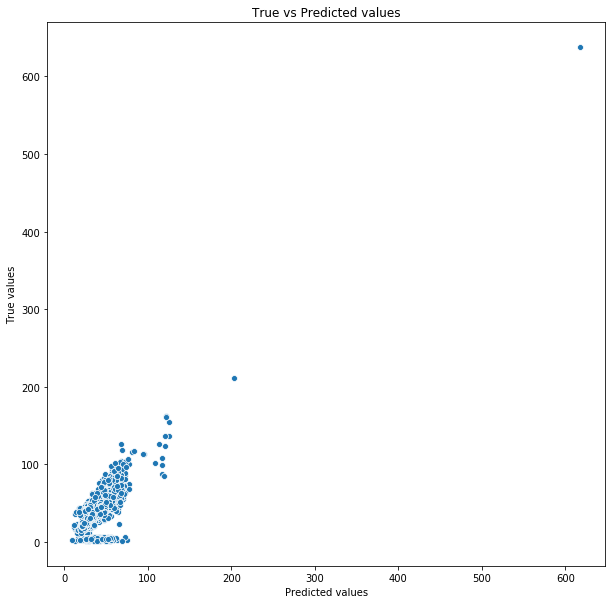

R2:	0.684
MAE:	4.971
MSE:	82.38


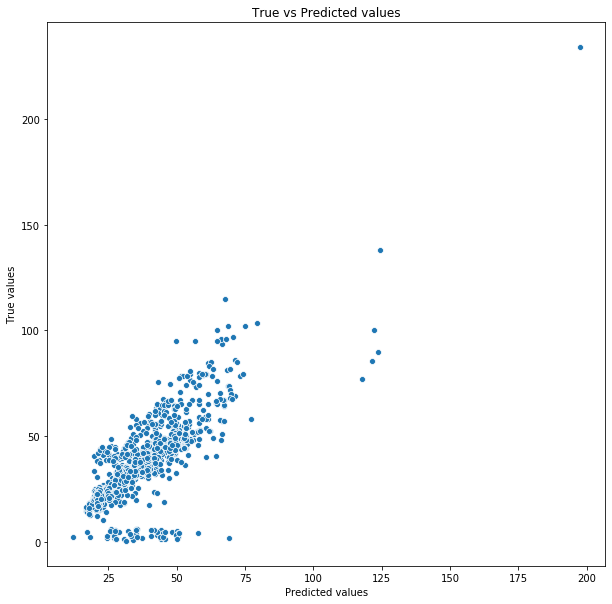

In [358]:
y_pred_=model_best.predict(X_train)
evaluate_preds(y_train, y_pred_)

y_pred_t=model_best.predict(X_test)
evaluate_preds(y_test, y_pred_t)

### 3.2. Восстаналиваем LifeSquare в пропущенных строках.

In [33]:
df_ls_m = pd.concat([df[(pd.isna(df['LifeSquare'])==True)],
                          df[df['LifeSquare']-df['Square']>0]]).reset_index()
# df_ls_m = df_ls_m.drop(['LifeSquare', 'Healthcare_1'], axis=1).reset_index()
df_ls_m.drop(['index'], axis=1, inplace=True)
df_ls_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2595 entries, 0 to 2594
Data columns (total 23 columns):
Id               2595 non-null int64
DistrictId       2595 non-null int64
Rooms            2595 non-null float64
Square           2595 non-null float64
LifeSquare       482 non-null float64
KitchenSquare    2595 non-null float64
Floor            2595 non-null int64
HouseFloor       2595 non-null float64
HouseYear        2595 non-null int64
Ecology_1        2595 non-null float64
Social_1         2595 non-null int64
Social_2         2595 non-null int64
Social_3         2595 non-null int64
Healthcare_1     914 non-null float64
Helthcare_2      2595 non-null int64
Shops_1          2595 non-null int64
Price            2595 non-null float64
Ecology_2_A      2595 non-null uint8
Ecology_2_B      2595 non-null uint8
Ecology_3_A      2595 non-null uint8
Ecology_3_B      2595 non-null uint8
Shops_2_A        2595 non-null uint8
Shops_2_B        2595 non-null uint8
dtypes: float64(8), int64(9)

In [34]:
scl_f = scl.transform(df_ls_m[features_std])

In [35]:
df_ls_m_std = df_ls_m.copy()
df_ls_m_std[features_std] =  pd.DataFrame(scl_f, columns=features_std)
#df_ls_m_std

In [36]:
X = df_ls_m_std[features_]

In [37]:
LifeSquare = model_best.predict(X)

In [38]:
df_ls_m[target_] =  pd.DataFrame(LifeSquare)
#df_ls_m = df_ls_m.drop(['index'], axis=1)

In [39]:
df_ls_m.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
2590,41,30,2.0,59.015896,40.791713,12.0,5,5.0,2016,0.000078,...,1046.0,3,23,126281.142781,0,1,0,1,0,1
2591,12918,23,2.0,51.440463,49.084736,51.0,3,17.0,2017,0.005767,...,NaN,0,0,88150.012510,0,1,0,1,0,1
2592,2737,27,3.0,123.430072,105.844629,123.0,5,10.0,2015,0.017647,...,NaN,0,0,234194.837047,0,1,0,1,0,1
2593,14001,73,1.0,44.098768,26.735051,1.0,7,24.0,2014,0.042032,...,1940.0,2,5,381937.404161,0,1,0,1,0,1
2594,16568,27,4.0,200.334539,85.764922,25.0,1,2.0,2013,0.041116,...,NaN,1,4,528560.506016,0,1,0,1,0,1


In [40]:
df_ls_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2595 entries, 0 to 2594
Data columns (total 23 columns):
Id               2595 non-null int64
DistrictId       2595 non-null int64
Rooms            2595 non-null float64
Square           2595 non-null float64
LifeSquare       2595 non-null float64
KitchenSquare    2595 non-null float64
Floor            2595 non-null int64
HouseFloor       2595 non-null float64
HouseYear        2595 non-null int64
Ecology_1        2595 non-null float64
Social_1         2595 non-null int64
Social_2         2595 non-null int64
Social_3         2595 non-null int64
Healthcare_1     914 non-null float64
Helthcare_2      2595 non-null int64
Shops_1          2595 non-null int64
Price            2595 non-null float64
Ecology_2_A      2595 non-null uint8
Ecology_2_B      2595 non-null uint8
Ecology_3_A      2595 non-null uint8
Ecology_3_B      2595 non-null uint8
Shops_2_A        2595 non-null uint8
Shops_2_B        2595 non-null uint8
dtypes: float64(8), int64(9

### 3.3. Склеиваем датасет с полным набором данных

In [41]:
2595+7405

10000

In [42]:
df_ls = df.copy()

df_ls = df_ls[pd.isna(df_ls['LifeSquare'])==False] #.reset_index()
df_ls = df_ls[df_ls['LifeSquare']-df_ls['Square']<0].reset_index()
df_ls.drop(['index'], axis=1, inplace=True)

#df_ls = df_ls.drop(['Healthcare_1'], axis=1)
#df_ls = df_ls.drop(['level_0'], axis=1)
#df_ls.info()
df_ls.info()
df_ls.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7405 entries, 0 to 7404
Data columns (total 23 columns):
Id               7405 non-null int64
DistrictId       7405 non-null int64
Rooms            7405 non-null float64
Square           7405 non-null float64
LifeSquare       7405 non-null float64
KitchenSquare    7405 non-null float64
Floor            7405 non-null int64
HouseFloor       7405 non-null float64
HouseYear        7405 non-null int64
Ecology_1        7405 non-null float64
Social_1         7405 non-null int64
Social_2         7405 non-null int64
Social_3         7405 non-null int64
Healthcare_1     4288 non-null float64
Helthcare_2      7405 non-null int64
Shops_1          7405 non-null int64
Price            7405 non-null float64
Ecology_2_A      7405 non-null uint8
Ecology_2_B      7405 non-null uint8
Ecology_3_A      7405 non-null uint8
Ecology_3_B      7405 non-null uint8
Shops_2_A        7405 non-null uint8
Shops_2_B        7405 non-null uint8
dtypes: float64(8), int64(

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
7400,48,13,3.0,80.631333,48.899083,10.0,11,14.0,1999,0.090799,...,NaN,5,15,350684.628560,0,1,0,1,0,1
7401,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,...,350.0,3,11,196684.316040,0,1,0,1,0,1
7402,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,...,NaN,0,5,189050.289571,0,1,0,1,1,0
7403,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,...,325.0,2,5,181595.339808,0,1,1,0,0,1
7404,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,...,30.0,2,8,218714.077615,0,1,0,1,0,1


In [43]:
df_ls_n = pd.concat([df_ls, df_ls_m], ignore_index=True)
#df_ls = df_ls.drop(['level_0'], axis=1)
df_ls_n = df_ls_n[['Id'] + features_[0:3] + [target_] + features_[3:-9] + ['Healthcare_1'] + features_[-9:]]
df_ls_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Price            10000 non-null float64
Ecology_2_A      10000 non-null uint8
Ecology_2_B      10000 non-null uint8
Ecology_3_A      10000 non-null uint8
Ecology_3_B      10000 non-null uint8
Shops_2_A        10000 non-null uint8
Shops_2_B        10000 non-null uint8
dty

In [361]:
df_ls_n.sort_values(['Id']).head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
5865,0,0,1.0,109.144492,84.613939,15.0,6,15.0,2011,0.319809,...,2857.0,5,8,289034.391871,0,1,0,1,0,1
4148,2,2,1.0,34.472263,16.069376,5.0,5,18.0,1969,0.000000,...,NaN,2,5,174548.966339,0,1,0,1,0,1
3589,5,5,3.0,57.607965,38.955672,5.0,3,9.0,1974,0.150818,...,2643.0,4,5,258091.883679,0,1,0,1,0,1
3309,6,6,1.0,42.466813,40.010160,1.0,14,17.0,2014,0.243205,...,540.0,0,0,127196.762031,0,1,0,1,0,1
9640,10,6,3.0,75.888156,50.497381,1.0,11,17.0,2014,0.243205,...,540.0,0,0,218500.747041,0,1,0,1,0,1


In [360]:
df.sort_values(['Id']).head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
7885,0,0,1.0,109.144492,84.613939,15.0,6,15.0,2011,0.319809,...,2857.0,5,8,289034.391871,0,1,0,1,0,1
5549,2,2,1.0,34.472263,16.069376,5.0,5,18.0,1969,0.000000,...,NaN,2,5,174548.966339,0,1,0,1,0,1
4808,5,5,3.0,57.607965,38.955672,5.0,3,9.0,1974,0.150818,...,2643.0,4,5,258091.883679,0,1,0,1,0,1
4447,6,6,1.0,42.466813,40.010160,1.0,14,17.0,2014,0.243205,...,540.0,0,0,127196.762031,0,1,0,1,0,1
2684,10,6,3.0,75.888156,78.324716,1.0,11,17.0,2014,0.243205,...,540.0,0,0,218500.747041,0,1,0,1,0,1


In [362]:
df_ls_n.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,...,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,36.651397,6.273300,8.526700,12.609400,3.990166e+03,0.118858,...,1142.904460,1.319500,4.231300,214138.857399,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,4859.01902,43.587592,0.839512,21.058732,18.586297,28.560917,5.241148,6.775974,2.005003e+05,0.119025,...,1021.517264,1.493601,4.806341,92872.293865,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.00000,0.000000,0.000000,1.136859,-13.214169,0.000000,1.000000,0.000000,1.910000e+03,0.000000,...,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,23.937250,1.000000,4.000000,9.000000,1.974000e+03,0.017647,...,350.000000,0.000000,1.000000,153872.633942,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,8394.50000,36.000000,2.000000,52.513310,33.122941,6.000000,7.000000,13.000000,1.977000e+03,0.075424,...,900.000000,1.000000,3.000000,192269.644879,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,12592.50000,75.000000,2.000000,65.900625,45.675831,9.000000,12.000000,17.000000,2.001000e+03,0.195781,...,1548.000000,2.000000,6.000000,249135.462171,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,16798.00000,209.000000,19.000000,641.065193,638.163193,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- в датсете присутвуют квартиры где площадь кухни более чем жилая площадь, этого не может быть, поэтому восстановим площадь

In [372]:
#print((df_ls_n['LifeSquare'] - df_ls_n['KitchenSquare']).sort_values())
((df_ls_n['LifeSquare'] - df_ls_n['KitchenSquare'])<0).value_counts()

False    9969
True       31
dtype: int64

### 4. Восстанавливаем KitchenSquare

1. вынести строки датасета где разница отрицательная и положительная
2. на строках с положительной разницей обучить модель
3. на строках отрицательной разницы восстановить данные
4. склеить датафрейм

# 4. Восстанавливаем Healthcare_1

In [47]:
df_he = df_ls_n.copy()

In [48]:
df_he.head()
df_he.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Price            10000 non-null float64
Ecology_2_A      10000 non-null uint8
Ecology_2_B      10000 non-null uint8
Ecology_3_A      10000 non-null uint8
Ecology_3_B      10000 non-null uint8
Shops_2_A        10000 non-null uint8
Shops_2_B        10000 non-null uint8
dty

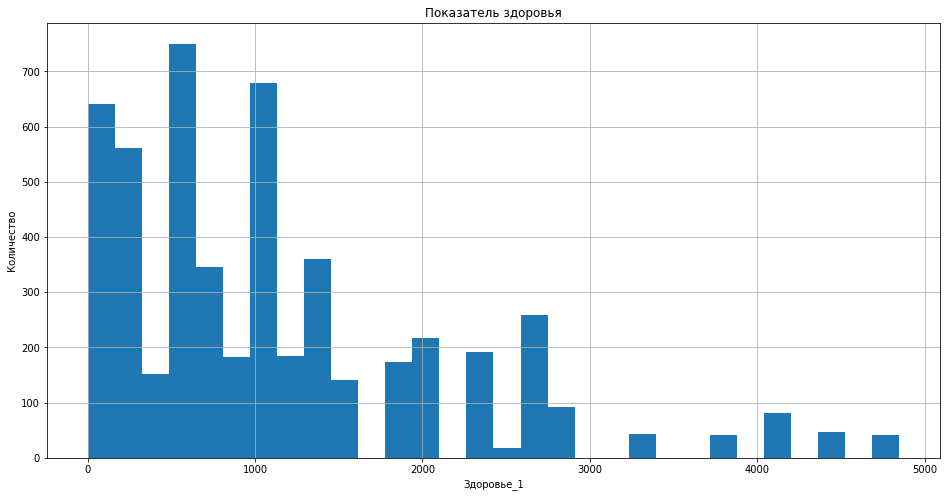

In [49]:
plt.figure(figsize = (16, 8))

df_he['Healthcare_1'].hist(bins=30)
plt.ylabel('Количество')
plt.xlabel('Здоровье_1')

plt.title('Показатель здоровья')
plt.show()

In [50]:
df_he = df_he[pd.isna(df_he['Healthcare_1'])==False].reset_index()
df_he.drop(['index'], axis=1, inplace=True)

In [51]:
df_he.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5202 entries, 0 to 5201
Data columns (total 23 columns):
Id               5202 non-null int64
DistrictId       5202 non-null int64
Rooms            5202 non-null float64
Square           5202 non-null float64
LifeSquare       5202 non-null float64
KitchenSquare    5202 non-null float64
Floor            5202 non-null int64
HouseFloor       5202 non-null float64
HouseYear        5202 non-null int64
Ecology_1        5202 non-null float64
Social_1         5202 non-null int64
Social_2         5202 non-null int64
Social_3         5202 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      5202 non-null int64
Shops_1          5202 non-null int64
Price            5202 non-null float64
Ecology_2_A      5202 non-null uint8
Ecology_2_B      5202 non-null uint8
Ecology_3_A      5202 non-null uint8
Ecology_3_B      5202 non-null uint8
Shops_2_A        5202 non-null uint8
Shops_2_B        5202 non-null uint8
dtypes: float64(8), int64(

In [52]:
feature_ = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
            'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
            'Social_3', 'Helthcare_2', 'Shops_1', 'Price', 'Ecology_2_A', 'Ecology_2_B',
            'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B']
target_ = 'Healthcare_1'

In [53]:
feature_std = df_he[feature_].select_dtypes(['int64', 'float64']).columns.tolist()

In [54]:
scl = StandardScaler()
scl_f = scl.fit_transform(df_he[feature_std])

In [55]:
df_he[feature_std] = pd.DataFrame(scl_f, columns=feature_std)

In [56]:
df_he.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,15053,-0.362885,1.315351,0.449430,0.265013,0.048632,-0.237201,-0.517638,-0.013884,-1.133994,...,240.0,-0.593482,2.075007,0.742942,0,1,0,1,0,1
1,4765,-0.109184,0.094138,-0.483483,-0.309951,-0.241239,-0.041527,-0.061600,-0.013920,-0.747232,...,229.0,-0.593482,-0.395667,-0.065494,0,1,0,1,0,1
2,5809,-0.003475,0.094138,-0.105335,0.936938,0.084866,-0.041527,0.698464,-0.013887,2.282172,...,1084.0,-1.252879,-0.015564,-0.528676,0,1,0,1,0,1
3,10783,0.863337,-1.127075,-0.721877,-0.597194,0.012398,0.545495,-0.061600,-0.013891,-1.038263,...,2078.0,0.065914,-0.205615,-0.788223,0,1,0,1,0,1
4,12915,0.017667,1.315351,1.110830,0.616510,0.193568,-0.628550,0.698464,-0.013765,1.280251,...,990.0,-1.252879,0.174488,-0.116888,0,1,0,1,0,1


In [57]:
X = df_he[feature_]
y = df_he[target_]

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 ,random_state=42)

In [59]:
X[pd.isna(X['LifeSquare'])==True]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B


In [60]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,-0.362885,1.315351,0.449430,0.265013,0.048632,-0.237201,-0.517638,-0.013884,-1.133994,1.345355,...,-0.381414,-0.593482,2.075007,0.742942,0,1,0,1,0,1
1,-0.109184,0.094138,-0.483483,-0.309951,-0.241239,-0.041527,-0.061600,-0.013920,-0.747232,0.434423,...,-0.412730,-0.593482,-0.395667,-0.065494,0,1,0,1,0,1
2,-0.003475,0.094138,-0.105335,0.936938,0.084866,-0.041527,0.698464,-0.013887,2.282172,-0.400598,...,-0.318781,-1.252879,-0.015564,-0.528676,0,1,0,1,0,1
3,0.863337,-1.127075,-0.721877,-0.597194,0.012398,0.545495,-0.061600,-0.013891,-1.038263,0.510334,...,-0.381414,0.065914,-0.205615,-0.788223,0,1,0,1,0,1
4,0.017667,1.315351,1.110830,0.616510,0.193568,-0.628550,0.698464,-0.013765,1.280251,0.510334,...,-0.287465,-1.252879,0.174488,-0.116888,0,1,0,1,0,1


**LinearRegression**

In [61]:
model_l = LinearRegression()

R2:	0.166
MAE:	673.294
MSE:	871123.122


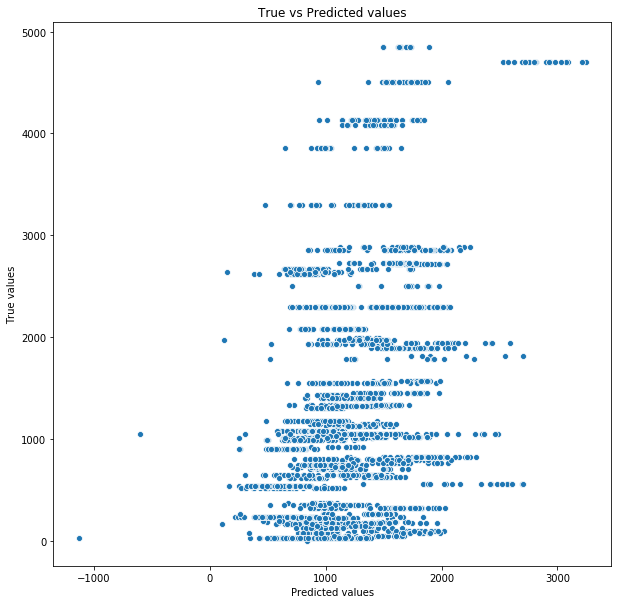

R2:	0.177
MAE:	665.835
MSE:	853739.168


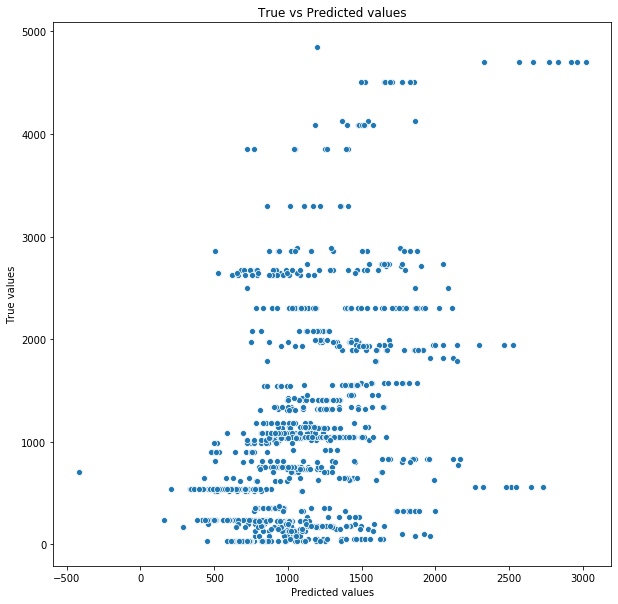

In [62]:
model_l.fit(X_train, y_train)
y_pred_l = model_l.predict(X_train)
evaluate_preds(y_train, y_pred_l)

y_pred_lt = model_l.predict(X_test)
evaluate_preds(y_test, y_pred_lt)

**RandomForest**

In [63]:
model_r = RandomForestRegressor()
model_r.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

R2:	0.999
MAE:	4.026
MSE:	1399.111


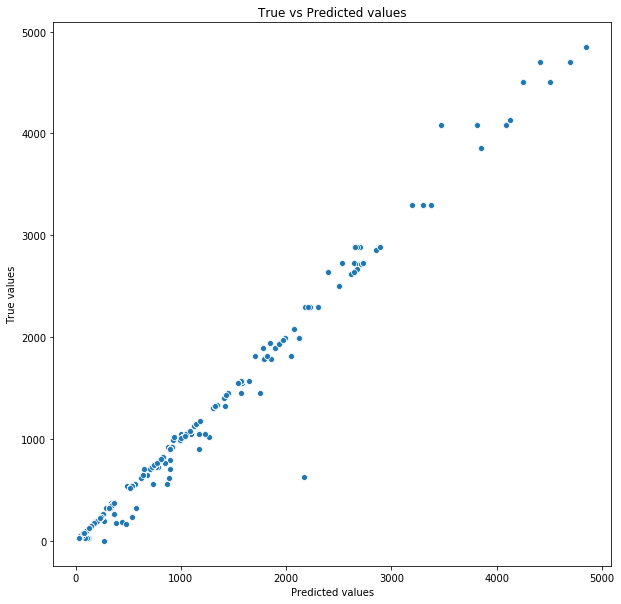

R2:	0.998
MAE:	7.584
MSE:	1954.474


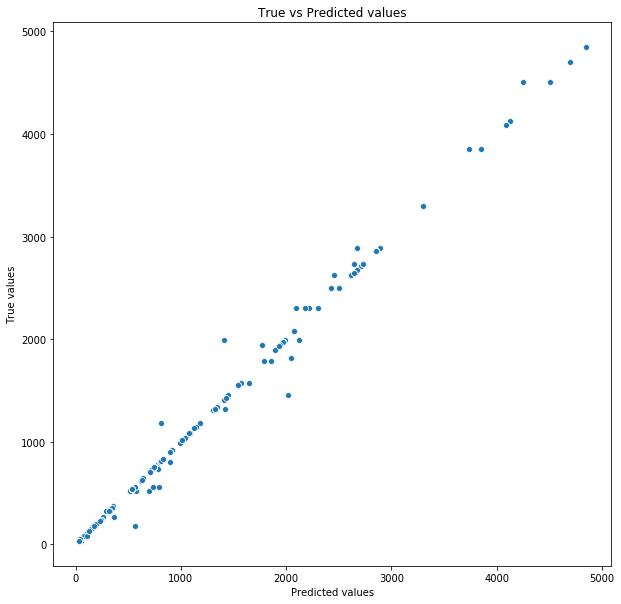

In [64]:
y_pred_R = model_r.predict(X_train)
evaluate_preds(y_train, y_pred_R)

y_pred_Rt = model_r.predict(X_test)
evaluate_preds(y_test, y_pred_Rt)

**Gradient Boosting**

In [65]:
model_g = GradientBoostingRegressor()
model_g.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.966
MAE:	127.186
MSE:	35560.806


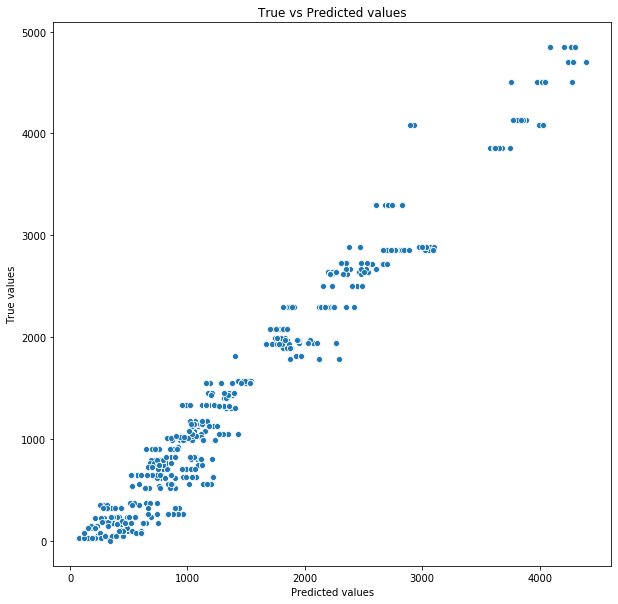

R2:	0.966
MAE:	129.626
MSE:	35338.849


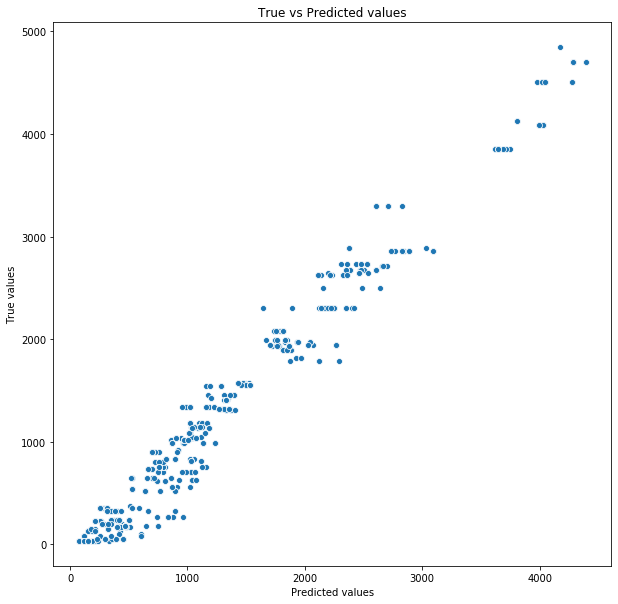

In [66]:
y_pred_G = model_g.predict(X_train)
evaluate_preds(y_train, y_pred_G)

y_pred_Gt = model_g.predict(X_test)
evaluate_preds(y_test, y_pred_Gt)

### 4.0 Поодбираем лучшие параметры

In [67]:
#model = RandomForestRegressormForestRegressormForestRegressor

### 4.1. Восстанавливаем Healthcare_1 методом Random Forest

In [68]:
df_he = df_ls_n.copy()
df_he = df_he[pd.isna(df_he['Healthcare_1'])==True].reset_index()
df_he.drop(['index'], axis=1, inplace=True)
df_he.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4798 entries, 0 to 4797
Data columns (total 23 columns):
Id               4798 non-null int64
DistrictId       4798 non-null int64
Rooms            4798 non-null float64
Square           4798 non-null float64
LifeSquare       4798 non-null float64
KitchenSquare    4798 non-null float64
Floor            4798 non-null int64
HouseFloor       4798 non-null float64
HouseYear        4798 non-null int64
Ecology_1        4798 non-null float64
Social_1         4798 non-null int64
Social_2         4798 non-null int64
Social_3         4798 non-null int64
Healthcare_1     0 non-null float64
Helthcare_2      4798 non-null int64
Shops_1          4798 non-null int64
Price            4798 non-null float64
Ecology_2_A      4798 non-null uint8
Ecology_2_B      4798 non-null uint8
Ecology_3_A      4798 non-null uint8
Ecology_3_B      4798 non-null uint8
Shops_2_A        4798 non-null uint8
Shops_2_B        4798 non-null uint8
dtypes: float64(8), int64(9),

In [69]:
df_he_std = df_he.copy()
scl_f = scl.transform(df_he_std[feature_std])
df_he_std[feature_std] = pd.DataFrame(scl_f, columns=feature_std)

In [70]:
X = df_he_std[feature_]

In [71]:
healthcare_1 = model_g.predict(X)

In [72]:
df_he[target_] =  pd.DataFrame(healthcare_1)

In [73]:
df_ = pd.concat([df_ls_n[pd.isna(df_ls_n['Healthcare_1'])==False], df_he], ignore_index=True)

In [74]:
df_ = df_[['Id'] + feature_[0:-9] + [target_] + feature_[-9:]]
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       10000 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     10000 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Price            10000 non-null float64
Ecology_2_A      10000 non-null uint8
Ecology_2_B      10000 non-null uint8
Ecology_3_A      10000 non-null uint8
Ecology_3_B      10000 non-null uint8
Shops_2_A        10000 non-null uint8
Shops_2_B        10000 non-null uint8
dt

### 5. Строим модель для прогнозирования цены=Price

In [236]:
df_p = df_.copy()

In [237]:
df_p.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,36.651397,6.273300,8.526700,12.609400,3.990166e+03,0.118858,...,986.491958,1.319500,4.231300,214138.857399,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,4859.01902,43.587592,0.839512,21.058732,18.586297,28.560917,5.241148,6.775974,2.005003e+05,0.119025,...,890.575882,1.493601,4.806341,92872.293865,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.00000,0.000000,0.000000,1.136859,-13.214169,0.000000,1.000000,0.000000,1.910000e+03,0.000000,...,-36.330523,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,23.937250,1.000000,4.000000,9.000000,1.974000e+03,0.017647,...,277.512482,0.000000,1.000000,153872.633942,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,8394.50000,36.000000,2.000000,52.513310,33.122941,6.000000,7.000000,13.000000,1.977000e+03,0.075424,...,750.000000,1.000000,3.000000,192269.644879,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,12592.50000,75.000000,2.000000,65.900625,45.675831,9.000000,12.000000,17.000000,2.001000e+03,0.195781,...,1437.453415,2.000000,6.000000,249135.462171,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,16798.00000,209.000000,19.000000,641.065193,638.163193,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,...,4849.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Ковариация параметров**

In [76]:
cov = StandardScaler()
cov_s = cov.fit_transform(df_p)

In [77]:
df_p_cov = pd.DataFrame(cov_s, columns=df_p.columns.tolist())

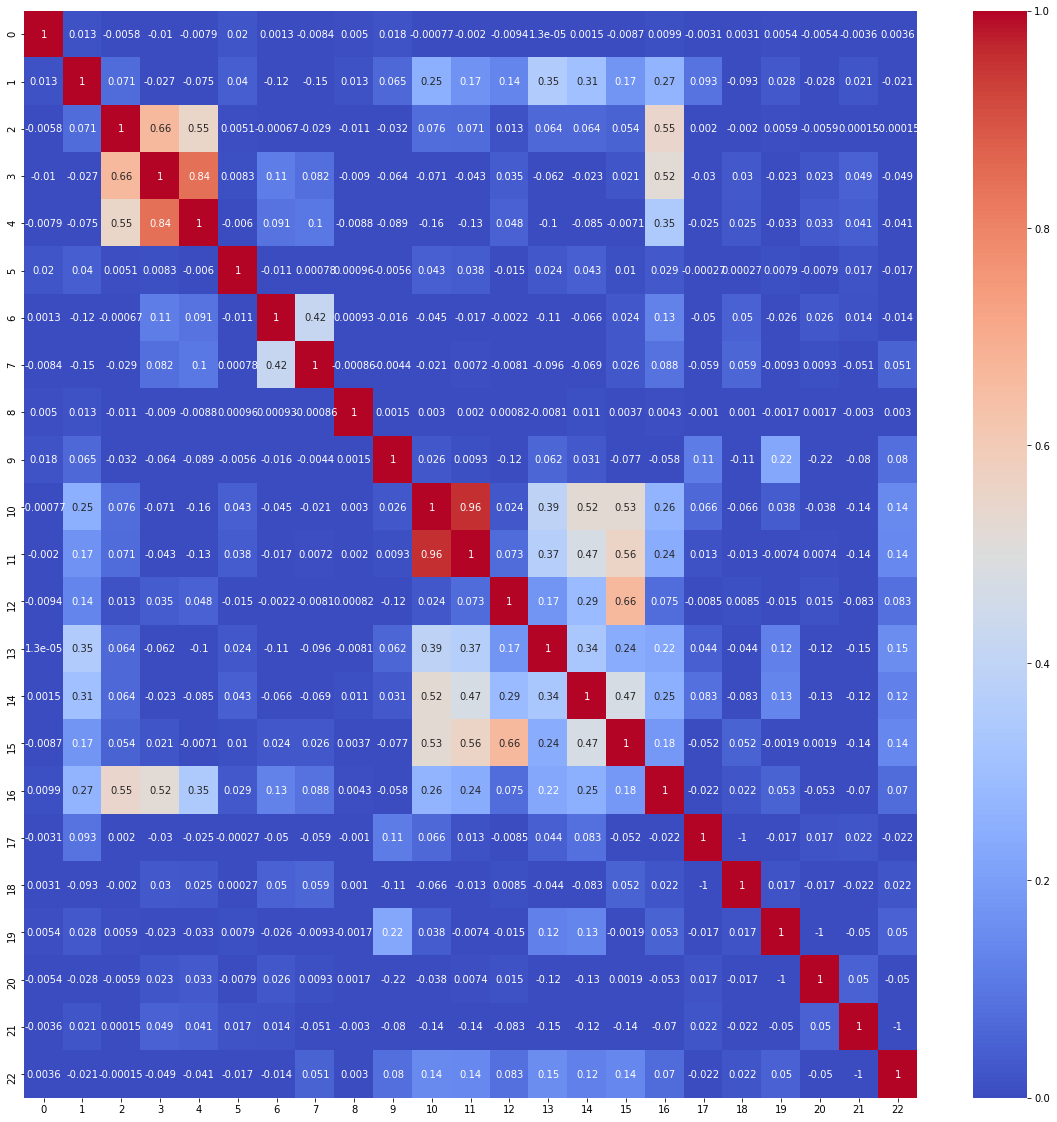

In [78]:
covariance_matrix = np.cov(df_p_cov.T)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(covariance_matrix, vmin=0, vmax=1, annot=True, cmap='coolwarm')

In [79]:
df_p.columns.to_list()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

In [209]:
# 'Id', 'DistrictId', 'HouseYear',
feature_ = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
            'Floor', 'HouseFloor',  'HouseYear', 'Ecology_1', 'Social_1', 'Social_2',
            'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Ecology_2_A',
            'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B']
target_ = 'Price'

In [210]:
feature_std = df_p[feature_].select_dtypes(['int64', 'float64']).columns.to_list()

In [215]:
feature_std

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

In [216]:
scl = StandardScaler()
scl_f = scl.fit_transform(df_p[feature_std])
len(scl_f)

10000

In [217]:
df_p[feature_std].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,-0.215687,1.321667,0.444867,0.182840,0.060460,-0.291306,-0.532703,-0.010036,-0.998053,1.215681,1.237169,-0.295384,-0.838255,-0.213923,2.448700
1,0.059635,0.130439,-0.539842,-0.401057,-0.219657,-0.100498,-0.089940,-0.010086,-0.581588,0.531208,0.600720,-0.337347,-0.850607,-0.213923,-0.256195
2,0.174352,0.130439,-0.140699,0.865203,0.095474,-0.100498,0.647998,-0.010041,2.680470,-0.096225,0.095553,-0.211458,0.109494,-0.883480,0.159943
3,1.115034,-1.060788,-0.791473,-0.692762,0.025445,0.471924,-0.089940,-0.010046,-0.894969,0.588247,0.105786,-0.295384,1.225682,0.455633,-0.048126
4,0.197295,1.321667,1.142989,0.539797,0.200518,-0.672921,0.647998,-0.009872,1.601602,0.588247,0.589738,-0.169496,0.003939,-0.883480,0.368011


In [218]:
df_p[feature_std] = pd.DataFrame(scl_f, columns=feature_std)

In [219]:
X = df_p[feature_]
y = df_p[target_]

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Linear Regression**

In [221]:
model_l = LinearRegression()
model_l.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

R2:	0.523
MAE:	44391.942
MSE:	4132987735.861


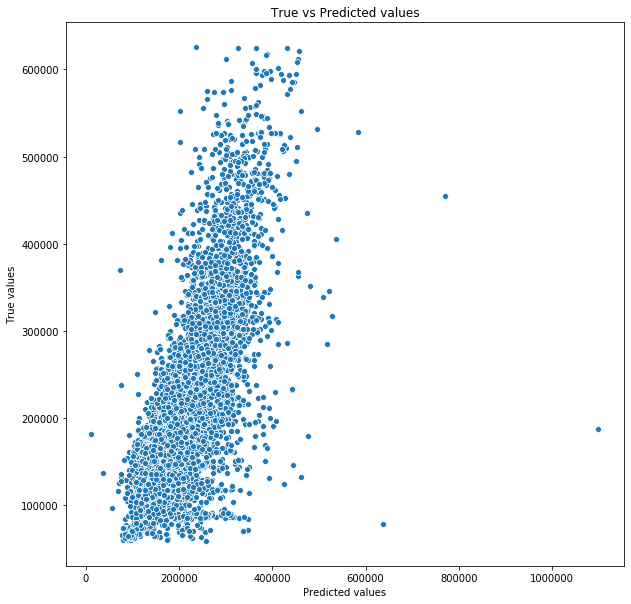

R2:	0.417
MAE:	45351.708
MSE:	4955360860.635


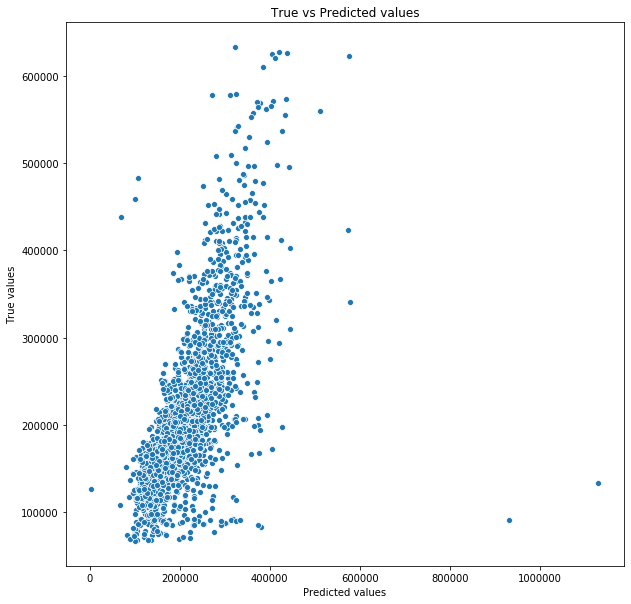

In [222]:
y_pred_l = model_l.predict(X_train)
evaluate_preds(y_train, y_pred_l)

y_pred_lt = model_l.predict(X_test)
evaluate_preds(y_test, y_pred_lt)

**Random Forest**

In [223]:
model_r = RandomForestRegressor()
model_r.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

R2:	0.95
MAE:	11881.613
MSE:	436390928.392


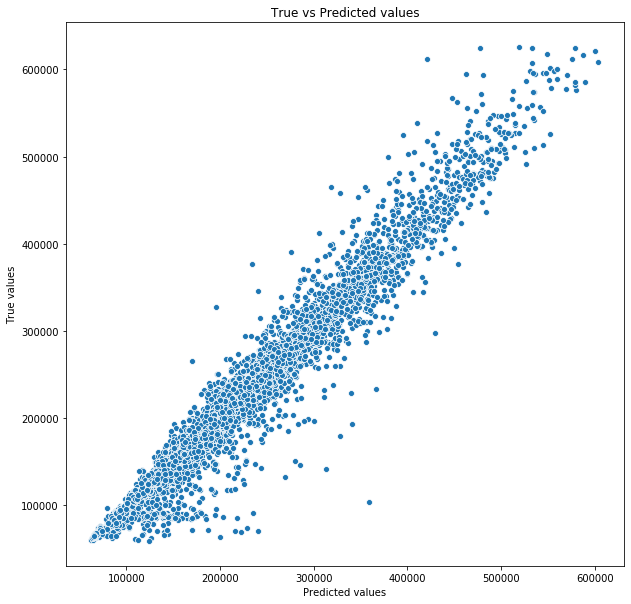

R2:	0.704
MAE:	29426.501
MSE:	2513741224.59


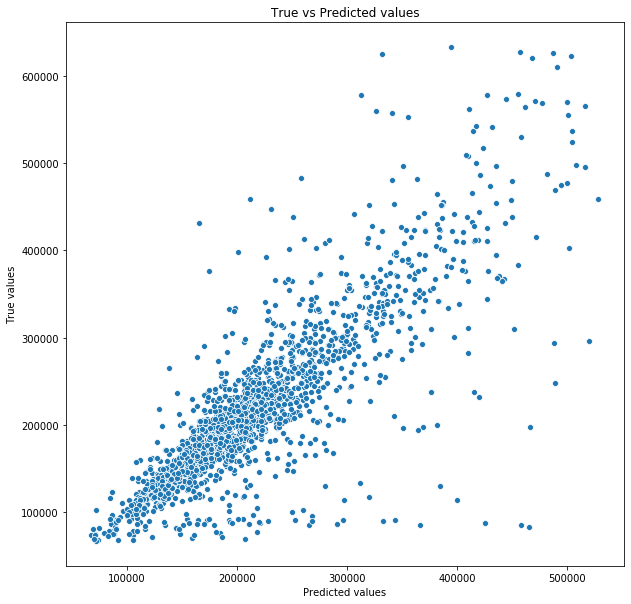

In [224]:
y_pred_r = model_r.predict(X_train)
evaluate_preds(y_train, y_pred_r)

y_pred_rt = model_r.predict(X_test)
evaluate_preds(y_test, y_pred_rt)

**Gradient Boosting**

In [225]:
model_g = GradientBoostingRegressor()
model_g.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.767
MAE:	28728.736
MSE:	2014174782.459


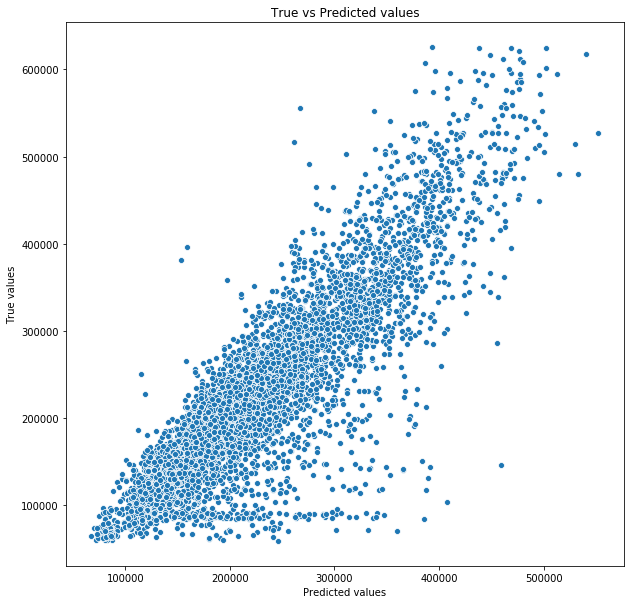

R2:	0.708
MAE:	30527.376
MSE:	2479821564.908


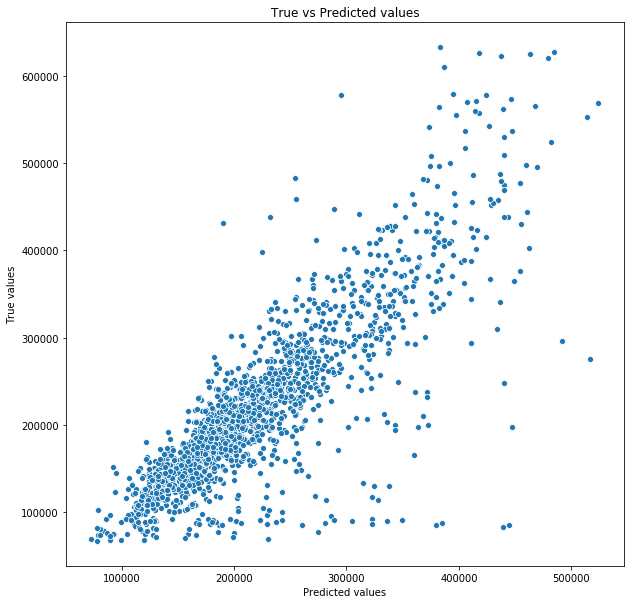

In [226]:
y_pred_g = model_g.predict(X_train)
evaluate_preds(y_train, y_pred_g)

y_pred_gt = model_g.predict(X_test)
evaluate_preds(y_test, y_pred_gt)

### 5.1. Настройка и оценка финальной модели

**Подбор гиперпараметров**

In [204]:
model = GradientBoostingRegressor(random_state=42)
model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [205]:
param={'n_estimators':[10, 50,100, 150, 300], 'max_depth':[3,5,7,10]}

In [206]:
gd=GridSearchCV(model, param, scoring='r2',cv = KFold(n_splits=3,random_state = 42))
gd.fit(X,y)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=False),
             error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                           

In [212]:
gd.best_params_

{'max_depth': 5, 'n_estimators': 150}

In [227]:
model = GradientBoostingRegressor(max_depth=gd.best_params_['max_depth'], 
                                  n_estimators=gd.best_params_['n_estimators'], 
                                  random_state=42,
                                  learning_rate=0.08,
                                  #alpha=0.01,
                                  subsample=0.9
                                 )
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.08, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=0.9, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.87
MAE:	21675.694
MSE:	1124208621.636


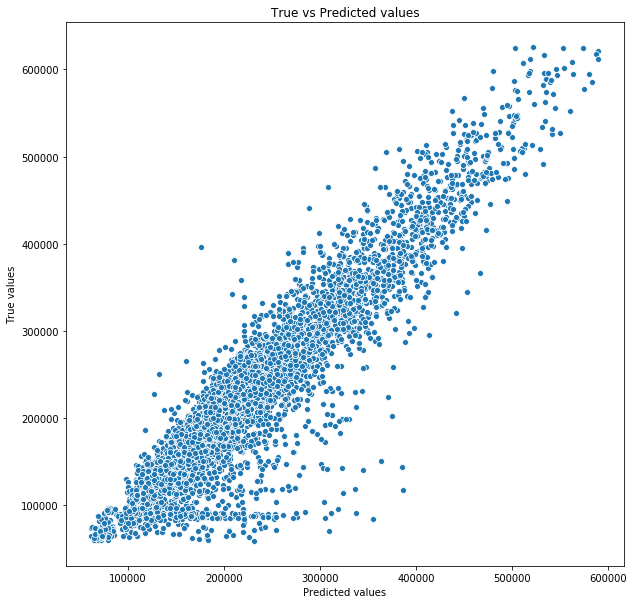

R2:	0.738
MAE:	27415.55
MSE:	2228829371.087


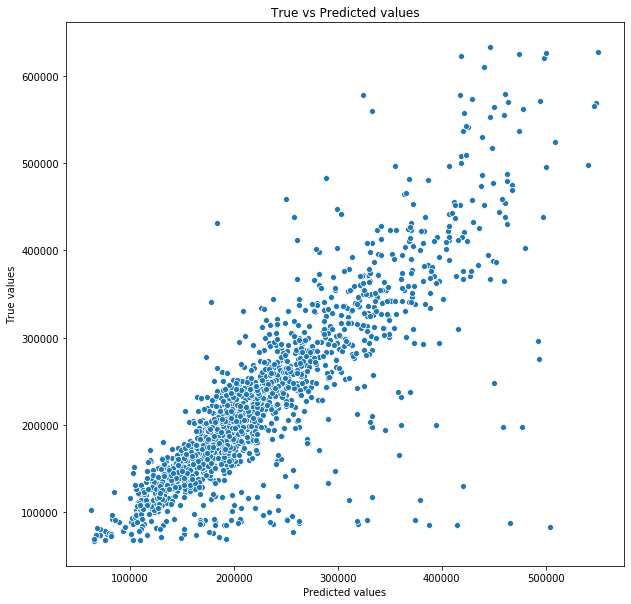

In [228]:
y_pred = model.predict(X_train)
evaluate_preds(y_train, y_pred)

y_pred_t = model.predict(X_test)
evaluate_preds(y_test, y_pred_t)